In [1]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import re
import numpy as np
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client

In [2]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        
        with h5py.File(file_path,'r') as h5:
            data = []
            growth_numbers = []

            # Iterate through the groups and match the pattern
            for key in h5.keys():
                match = re.match(r'growth_(\d+)', key)
                if match:
                    growth_number = int(match.group(1))
                    growth_numbers.append(growth_number)

                    # Extract the corresponding dataset
                    dataset = np.array(h5[key]["spot_2"])
                    data.append(dataset)
                    
            # Concatenate all the datasets and normalize
            data = np.vstack(data)
            
        self.data = data
       
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = (self.data[index]).astype(np.float32)
        image_max = np.max(image)
        image /= image_max
        return image, image_max

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'
    

combined_dataset = HDF5Dataset(file_path)

# Create a data loader for the combined dataset
batch_size = 1000
data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)




In [3]:
"""
    The below code uses the "traditional" method to provide close fits that the model uses for standardization later
"""


import numpy as np
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
import h5py

# Defining the 2D Gaussian function
def gaussian2D(x_y, A, x0, y0, sigma_x, sigma_y):
    x, y = x_y
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))


# Computing residuals for least-squares minimization
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian2D((x, y), A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y
    
    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0
    
    return mean_x, mean_y, cov_x, cov_y, theta

# Fitting multiple images using Dask
def fit_and_convert_parameters(h5_filename):
    all_converted_params = []  
    all_images=[]
    
    with h5py.File(h5_filename, 'r') as h5_file:
        for group_num in range(1, 13):  
            group_name = f'growth_{group_num}'
            if group_name in h5_file:
                group = h5_file[group_name]['spot_2']

                images = group[:]  
                
                normalized_images = [image / image.max() for image in images]  
                all_images.extend(normalized_images)
                
                guesses = [add_guess(image) for image in normalized_images]
                fits = [fit_gaussian2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
                
                converted_params = [convert_parameters(params) for params in compute(*fits)]
                all_converted_params.extend(converted_params)  

    return all_converted_params, all_images


# Parallelizing the fit function using Dask's delayed
@delayed
def fit_gaussian2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x

# Adding an initial guess for the fit
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Main code
if __name__ == "__main__":
    h5_filename = "/home/ferroelectric/sean/RHEED_4848_test6.h5"  # Replace with the actual path
    
    with Client() as client:  # Starts a local cluster or connects to an existing one
        results ,images2= fit_and_convert_parameters(h5_filename)


/tmp/ipykernel_47115/368317689.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)


In [4]:
"""This is the standard scaler being fit on the traditional data."""
from sklearn.preprocessing import StandardScaler
output_scaler = StandardScaler()
data=results #structed like [[meanx1,meany1,covx1,covy1,theta1],[meanx2,meany2,covx2,covy2,theta2]]
output_scaler.fit(data)


StandardScaler()

In [5]:
class LeNet5(nn.Module):
     def __init__(self,func,num_classes, testing=False):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 98)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(98, 52)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(52, num_classes)
        self.func = func
        self.testing=testing
        self.flatten=nn.Flatten()

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)

        out = self.flatten(out)
        
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        
        #need to use this below equation, as output_scaler.inverse_transform() doesnt work with gradients/numpy conversions.  
        unscaled_param = embedding * torch.tensor(output_scaler.var_ ** 0.5).cuda() + torch.tensor(output_scaler.mean_).cuda()
        
        unscaled_param[:,4]=(math.pi/4)*(nn.Tanh()(unscaled_param[:,4]) + 1)#makes sure the rotation is in the correct range

        final = self.func(unscaled_param)
        
        
        if self.testing==True:
            return  embedding, unscaled_param, final 
        
        return final

    


In [6]:
class LeNet5_inference(nn.Module):
     def __init__(self,num_classes):
        super(LeNet5_inference, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 98)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(98, 52)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(52, num_classes)
        self.flatten=nn.Flatten()
        

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        embedding = embedding * torch.tensor(output_scaler.var_ ** 0.5) + torch.tensor(output_scaler.mean_)#unscaling
        
        return embedding

    


Generated Image Shape: torch.Size([1, 1, 48, 48])


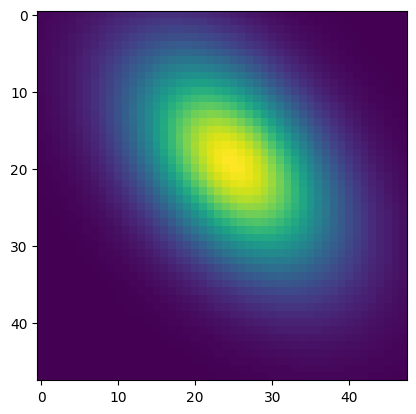

In [7]:
class GaussianGenerator(nn.Module):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        #these 2 lines have been changed around to fix the mean_x problem, but its causing another problem, training worse. commented out is old version
        x = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)
        # x = torch.arange(48, dtype=torch.float32).reshape(1, -1).repeat(48, 1).to(params.device) 
        # y = torch.arange(48, dtype=torch.float32).reshape(-1, 1).repeat(1, 48).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)
        
        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)
        
        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))

        return img.unsqueeze(1)
    
    
img_dim = (48, 48)  # Replace with the desired image dimensions
model = GaussianGenerator(img_dim)
sample_params = torch.tensor([19.2763, 24.8520, 11.2061,  6.8914,  0.7006], dtype=torch.float32)

# Reshape the sample_params tensor to have a batch dimension
sample_params_batched = sample_params.unsqueeze(0)
# Call the model to generate the Gaussian image
generated_img = model(sample_params_batched)


# Display the generated image shape
print("Generated Image Shape:", generated_img.shape)
plt.imshow(generated_img.squeeze(0).squeeze(0))

In [8]:
def custom_weighted_mse_loss(I, J, n):
    """
    Compute the custom weighted MSE loss between two grayscale images I and J.

    Parameters:
    - I: torch.Tensor of shape [batch_size, 1, M, N], the input image
    - J: torch.Tensor of shape [batch_size, 1, M, N], the target image
    - n: int, the exponent to raise the input image for the weight

    Returns:
    - loss: torch.Tensor, the computed loss
    """
    # Compute the weight
    W = torch.pow(I, n)

    # Compute the squared differences
    squared_diffs = torch.pow(I - J, 2)

    # Compute the weighted squared differences
    weighted_squared_diffs = W * squared_diffs

    # Compute the loss
    loss = torch.mean(weighted_squared_diffs)

    return loss

 

# Test the function
I = torch.randn(16, 1, 128, 128)  # Batch of 16 128x128 grayscale images
J = torch.randn(16, 1, 128, 128)  # Batch of 16 128x128 grayscale images
n = 2  # Exponent value

 

loss = custom_weighted_mse_loss(I, J, n)
print("Custom Weighted MSE Loss:", loss.item())

Custom Weighted MSE Loss: 4.048843860626221


In [15]:
#TRAINING LOOP

net = LeNet5(GaussianGenerator((48,48)).float(),5,testing=True).cuda().float() 


best_loss = float('inf')
# best_model_path = 'best-model.pt'

num_epochs = 200
lr=1e-6


optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=1e-3, steps_per_epoch=len(data_loader))

n=1
scaled_tensors = []
unscaled_tensors = []
from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    
    if epoch%10 ==0:
        n+=0.1

    for i, (images, image_max) in enumerate(tqdm(data_loader)):
        
        images = images.unsqueeze(1)
        optimizer.zero_grad()
        scaled,unscaled, outputs = net(images.cuda())

        loss=custom_weighted_mse_loss(images.cuda().float(), outputs.float(), n)
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        scheduler.step()
            
        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")


  3%|▎         | 4/151 [00:00<00:07, 19.41it/s]

100%|██████████| 151/151 [00:06<00:00, 22.31it/s]


Epoch [1/200], Loss: 0.00902097418114839


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [2/200], Loss: 0.005504073630648338


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [3/200], Loss: 0.004522142848555023


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [4/200], Loss: 0.004153078915366274


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [5/200], Loss: 0.003863857187861145


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [6/200], Loss: 0.0036287620040705267


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [7/200], Loss: 0.0034979496888248927


100%|██████████| 151/151 [00:06<00:00, 22.34it/s]


Epoch [8/200], Loss: 0.0034508268311866466


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [9/200], Loss: 0.003424418345402112


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [10/200], Loss: 0.0034048686633564975


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [11/200], Loss: 0.0030561966809215923


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [12/200], Loss: 0.0030453020833210638


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [13/200], Loss: 0.0030357729140915815


100%|██████████| 151/151 [00:06<00:00, 22.37it/s]


Epoch [14/200], Loss: 0.0030286228392174507


100%|██████████| 151/151 [00:06<00:00, 22.78it/s]


Epoch [15/200], Loss: 0.0030227363593753006


100%|██████████| 151/151 [00:06<00:00, 22.89it/s]


Epoch [16/200], Loss: 0.0030166127700481985


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [17/200], Loss: 0.0030121231507139884


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [18/200], Loss: 0.003006723209820836


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [19/200], Loss: 0.0030012631091899823


100%|██████████| 151/151 [00:06<00:00, 22.37it/s]


Epoch [20/200], Loss: 0.002998992350470546


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [21/200], Loss: 0.002701689348870654


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [22/200], Loss: 0.002702940275448541


100%|██████████| 151/151 [00:06<00:00, 22.90it/s]


Epoch [23/200], Loss: 0.0027029854615545825


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [24/200], Loss: 0.0026999115681781475


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [25/200], Loss: 0.00270252581839974


100%|██████████| 151/151 [00:06<00:00, 22.41it/s]


Epoch [26/200], Loss: 0.0026975141280016165


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [27/200], Loss: 0.002698580737515593


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [28/200], Loss: 0.0026980222662331054


100%|██████████| 151/151 [00:06<00:00, 23.06it/s]


Epoch [29/200], Loss: 0.0026968315178960167


100%|██████████| 151/151 [00:06<00:00, 23.08it/s]


Epoch [30/200], Loss: 0.002698743829984736


100%|██████████| 151/151 [00:06<00:00, 23.13it/s]


Epoch [31/200], Loss: 0.002434742971576306


100%|██████████| 151/151 [00:06<00:00, 22.48it/s]


Epoch [32/200], Loss: 0.002434866903781496


100%|██████████| 151/151 [00:06<00:00, 23.06it/s]


Epoch [33/200], Loss: 0.0024340516989372228


100%|██████████| 151/151 [00:06<00:00, 23.06it/s]


Epoch [34/200], Loss: 0.0024346059823519743


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [35/200], Loss: 0.00243582727930305


100%|██████████| 151/151 [00:06<00:00, 23.14it/s]


Epoch [36/200], Loss: 0.002435480620687371


100%|██████████| 151/151 [00:06<00:00, 23.15it/s]


Epoch [37/200], Loss: 0.0024334013443563555


100%|██████████| 151/151 [00:06<00:00, 22.52it/s]


Epoch [38/200], Loss: 0.0024388394155076994


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [39/200], Loss: 0.0024363502200125463


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [40/200], Loss: 0.0024343854886485846


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [41/200], Loss: 0.0022004259710156956


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [42/200], Loss: 0.0021990528391883863


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [43/200], Loss: 0.0022002304086942742


100%|██████████| 151/151 [00:06<00:00, 22.43it/s]


Epoch [44/200], Loss: 0.0021987116729088175


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [45/200], Loss: 0.002199260447026286


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [46/200], Loss: 0.0022012794340979186


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [47/200], Loss: 0.0021991584887913126


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [48/200], Loss: 0.002200141285441273


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [49/200], Loss: 0.002200061557136032


100%|██████████| 151/151 [00:06<00:00, 22.48it/s]


Epoch [50/200], Loss: 0.0021988699530306834


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [51/200], Loss: 0.0019903205611144768


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [52/200], Loss: 0.0019904870049571558


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [53/200], Loss: 0.00199116128018829


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [54/200], Loss: 0.001990097662779373


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [55/200], Loss: 0.0019909706327521444


100%|██████████| 151/151 [00:06<00:00, 22.43it/s]


Epoch [56/200], Loss: 0.001992117358365448


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [57/200], Loss: 0.001990336502303943


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [58/200], Loss: 0.001991890905122735


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [59/200], Loss: 0.0019912706758974997


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [60/200], Loss: 0.0019896555821479157


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [61/200], Loss: 0.001803830512706807


100%|██████████| 151/151 [00:06<00:00, 22.39it/s]


Epoch [62/200], Loss: 0.0018036838810557858


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [63/200], Loss: 0.0018036224045143124


100%|██████████| 151/151 [00:06<00:00, 22.84it/s]


Epoch [64/200], Loss: 0.0018040372963859053


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [65/200], Loss: 0.001804064759608383


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [66/200], Loss: 0.0018048387079419481


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [67/200], Loss: 0.0018034387736069347


100%|██████████| 151/151 [00:06<00:00, 22.46it/s]


Epoch [68/200], Loss: 0.0018032656948618738


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [69/200], Loss: 0.0018035646787048964


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [70/200], Loss: 0.0018033018807529022


100%|██████████| 151/151 [00:06<00:00, 23.08it/s]


Epoch [71/200], Loss: 0.0016355586056258308


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [72/200], Loss: 0.0016354250387035755


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [73/200], Loss: 0.0016358164817538877


100%|██████████| 151/151 [00:06<00:00, 22.35it/s]


Epoch [74/200], Loss: 0.0016347888767694599


100%|██████████| 151/151 [00:06<00:00, 22.87it/s]


Epoch [75/200], Loss: 0.001635120106885666


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [76/200], Loss: 0.0016357387633476135


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [77/200], Loss: 0.0016358605584450411


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [78/200], Loss: 0.0016357911872486306


100%|██████████| 151/151 [00:06<00:00, 22.90it/s]


Epoch [79/200], Loss: 0.0016358170322210387


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [80/200], Loss: 0.0016354304577982583


100%|██████████| 151/151 [00:06<00:00, 22.37it/s]


Epoch [81/200], Loss: 0.0014857134877377196


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [82/200], Loss: 0.001486601629479486


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [83/200], Loss: 0.0014856583708650526


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [84/200], Loss: 0.0014849455290110102


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [85/200], Loss: 0.0014846519519272723


100%|██████████| 151/151 [00:06<00:00, 22.43it/s]


Epoch [86/200], Loss: 0.001484721654637513


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [87/200], Loss: 0.0014852166626084325


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [88/200], Loss: 0.0014856094579267878


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [89/200], Loss: 0.0014859888361865618


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [90/200], Loss: 0.001484796745603941


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [91/200], Loss: 0.0013502641721314054


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [92/200], Loss: 0.0013502519369581775


100%|██████████| 151/151 [00:06<00:00, 22.33it/s]


Epoch [93/200], Loss: 0.0013504704747299683


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [94/200], Loss: 0.001349866838928386


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [95/200], Loss: 0.001349885676623575


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [96/200], Loss: 0.0013501913493363471


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [97/200], Loss: 0.001350527688620353


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [98/200], Loss: 0.001350227419583016


100%|██████████| 151/151 [00:06<00:00, 22.34it/s]


Epoch [99/200], Loss: 0.0013499686051937228


100%|██████████| 151/151 [00:06<00:00, 22.85it/s]


Epoch [100/200], Loss: 0.001350362280180172


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [101/200], Loss: 0.0012290665250740305


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [102/200], Loss: 0.001229212974006964


100%|██████████| 151/151 [00:06<00:00, 23.01it/s]


Epoch [103/200], Loss: 0.0012291542821816655


100%|██████████| 151/151 [00:06<00:00, 23.01it/s]


Epoch [104/200], Loss: 0.0012294638767801473


100%|██████████| 151/151 [00:06<00:00, 22.38it/s]


Epoch [105/200], Loss: 0.0012290036214811617


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [106/200], Loss: 0.0012289548056841587


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [107/200], Loss: 0.0012294137441793715


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [108/200], Loss: 0.0012287950576498907


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [109/200], Loss: 0.0012294637187328559


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [110/200], Loss: 0.0012290913747339848


100%|██████████| 151/151 [00:06<00:00, 22.44it/s]


Epoch [111/200], Loss: 0.0011200937534997005


100%|██████████| 151/151 [00:06<00:00, 23.06it/s]


Epoch [112/200], Loss: 0.0011202506289280803


100%|██████████| 151/151 [00:06<00:00, 22.85it/s]


Epoch [113/200], Loss: 0.0011201461750878306


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [114/200], Loss: 0.001119891288751946


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [115/200], Loss: 0.0011198877014639164


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [116/200], Loss: 0.0011202048430132944


100%|██████████| 151/151 [00:06<00:00, 22.39it/s]


Epoch [117/200], Loss: 0.0011197762071950646


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [118/200], Loss: 0.0011203425438359182


100%|██████████| 151/151 [00:06<00:00, 23.01it/s]


Epoch [119/200], Loss: 0.0011200791853942617


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [120/200], Loss: 0.001120236662944273


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [121/200], Loss: 0.001022115682054385


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [122/200], Loss: 0.0010218012157445218


100%|██████████| 151/151 [00:06<00:00, 22.29it/s]


Epoch [123/200], Loss: 0.0010219289769344525


100%|██████████| 151/151 [00:06<00:00, 22.89it/s]


Epoch [124/200], Loss: 0.0010216617563566723


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [125/200], Loss: 0.0010222420273718752


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [126/200], Loss: 0.0010218437520528075


100%|██████████| 151/151 [00:06<00:00, 23.01it/s]


Epoch [127/200], Loss: 0.0010220449801768786


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [128/200], Loss: 0.0010220041654276236


100%|██████████| 151/151 [00:06<00:00, 22.37it/s]


Epoch [129/200], Loss: 0.0010218948414179169


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [130/200], Loss: 0.0010218121025045187


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [131/200], Loss: 0.0009335876883482499


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [132/200], Loss: 0.0009337639727549541


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [133/200], Loss: 0.0009335480936469868


100%|██████████| 151/151 [00:06<00:00, 23.01it/s]


Epoch [134/200], Loss: 0.0009336412756315228


100%|██████████| 151/151 [00:06<00:00, 22.36it/s]


Epoch [135/200], Loss: 0.0009338701562493398


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [136/200], Loss: 0.0009333564798094776


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [137/200], Loss: 0.0009335564427842565


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [138/200], Loss: 0.0009336722436490537


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [139/200], Loss: 0.0009334682458425743


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [140/200], Loss: 0.0009334410420489429


100%|██████████| 151/151 [00:06<00:00, 22.35it/s]


Epoch [141/200], Loss: 0.0008538917619858356


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [142/200], Loss: 0.0008536898951194194


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [143/200], Loss: 0.000853777154956309


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [144/200], Loss: 0.0008536733406293668


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [145/200], Loss: 0.0008539720149309874


100%|██████████| 151/151 [00:06<00:00, 22.85it/s]


Epoch [146/200], Loss: 0.0008537725476850293


100%|██████████| 151/151 [00:06<00:00, 22.34it/s]


Epoch [147/200], Loss: 0.0008538546351352028


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [148/200], Loss: 0.0008537385632771233


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [149/200], Loss: 0.0008537398118507241


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [150/200], Loss: 0.0008539007598879618


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [151/200], Loss: 0.0007818649994789172


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [152/200], Loss: 0.0007820136013243421


100%|██████████| 151/151 [00:06<00:00, 22.36it/s]


Epoch [153/200], Loss: 0.0007818603374693074


100%|██████████| 151/151 [00:06<00:00, 23.00it/s]


Epoch [154/200], Loss: 0.0007818515535092462


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [155/200], Loss: 0.000781782412445111


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [156/200], Loss: 0.0007819621727357785


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [157/200], Loss: 0.0007818772604793853


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [158/200], Loss: 0.0007819527812573491


100%|██████████| 151/151 [00:06<00:00, 22.40it/s]


Epoch [159/200], Loss: 0.0007818408961105623


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [160/200], Loss: 0.0007817060717486388


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [161/200], Loss: 0.0007168566476590685


100%|██████████| 151/151 [00:06<00:00, 22.92it/s]


Epoch [162/200], Loss: 0.0007168700099793194


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [163/200], Loss: 0.0007169059140835919


100%|██████████| 151/151 [00:06<00:00, 22.84it/s]


Epoch [164/200], Loss: 0.0007169366357786371


100%|██████████| 151/151 [00:06<00:00, 22.94it/s]


Epoch [165/200], Loss: 0.0007168525692679926


100%|██████████| 151/151 [00:06<00:00, 22.38it/s]


Epoch [166/200], Loss: 0.000716777473290309


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [167/200], Loss: 0.0007168061615720342


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [168/200], Loss: 0.0007170563122714


100%|██████████| 151/151 [00:06<00:00, 22.89it/s]


Epoch [169/200], Loss: 0.0007166994461135951


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [170/200], Loss: 0.000716666759235402


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [171/200], Loss: 0.0006581703235629626


100%|██████████| 151/151 [00:06<00:00, 22.32it/s]


Epoch [172/200], Loss: 0.0006580792867812939


100%|██████████| 151/151 [00:06<00:00, 22.95it/s]


Epoch [173/200], Loss: 0.0006580135830530021


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [174/200], Loss: 0.0006580001613686466


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [175/200], Loss: 0.000658037933514805


100%|██████████| 151/151 [00:06<00:00, 22.87it/s]


Epoch [176/200], Loss: 0.000658015320416762


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [177/200], Loss: 0.0006580302778582107


100%|██████████| 151/151 [00:06<00:00, 22.35it/s]


Epoch [178/200], Loss: 0.0006579647533786761


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [179/200], Loss: 0.000658038301263868


100%|██████████| 151/151 [00:06<00:00, 22.96it/s]


Epoch [180/200], Loss: 0.0006579664051656099


100%|██████████| 151/151 [00:06<00:00, 22.98it/s]


Epoch [181/200], Loss: 0.0006048309582822172


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [182/200], Loss: 0.0006047956902219217


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [183/200], Loss: 0.0006048514176968066


100%|██████████| 151/151 [00:06<00:00, 22.21it/s]


Epoch [184/200], Loss: 0.0006048316652547346


100%|██████████| 151/151 [00:06<00:00, 22.89it/s]


Epoch [185/200], Loss: 0.0006048156400303671


100%|██████████| 151/151 [00:06<00:00, 22.84it/s]


Epoch [186/200], Loss: 0.0006047929305620245


100%|██████████| 151/151 [00:06<00:00, 23.04it/s]


Epoch [187/200], Loss: 0.0006047805546881594


100%|██████████| 151/151 [00:06<00:00, 23.05it/s]


Epoch [188/200], Loss: 0.0006048163512431775


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [189/200], Loss: 0.0006047920347037201


100%|██████████| 151/151 [00:06<00:00, 22.37it/s]


Epoch [190/200], Loss: 0.0006048180504442988


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [191/200], Loss: 0.0005566607489996891


100%|██████████| 151/151 [00:06<00:00, 22.93it/s]


Epoch [192/200], Loss: 0.0005566202237468139


100%|██████████| 151/151 [00:06<00:00, 22.91it/s]


Epoch [193/200], Loss: 0.0005566236383392667


100%|██████████| 151/151 [00:06<00:00, 22.90it/s]


Epoch [194/200], Loss: 0.0005566153655272742


100%|██████████| 151/151 [00:06<00:00, 22.87it/s]


Epoch [195/200], Loss: 0.0005565932381355408


100%|██████████| 151/151 [00:06<00:00, 22.33it/s]


Epoch [196/200], Loss: 0.0005566013112682725


100%|██████████| 151/151 [00:06<00:00, 23.02it/s]


Epoch [197/200], Loss: 0.0005566093535625086


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]


Epoch [198/200], Loss: 0.0005566045766795017


100%|██████████| 151/151 [00:06<00:00, 23.03it/s]


Epoch [199/200], Loss: 0.0005565760109807976


100%|██████████| 151/151 [00:06<00:00, 22.99it/s]

Epoch [200/200], Loss: 0.0005566389303783955


In [16]:
with torch.no_grad():
  dev=torch.device("cuda")
  data, image_max = next(iter(data_loader))
  data=data.unsqueeze(1)
  data_ = data.cpu()
  optimizer.zero_grad()
  scaled, unscaled, outputs = net(data.to('cuda'))
  
  

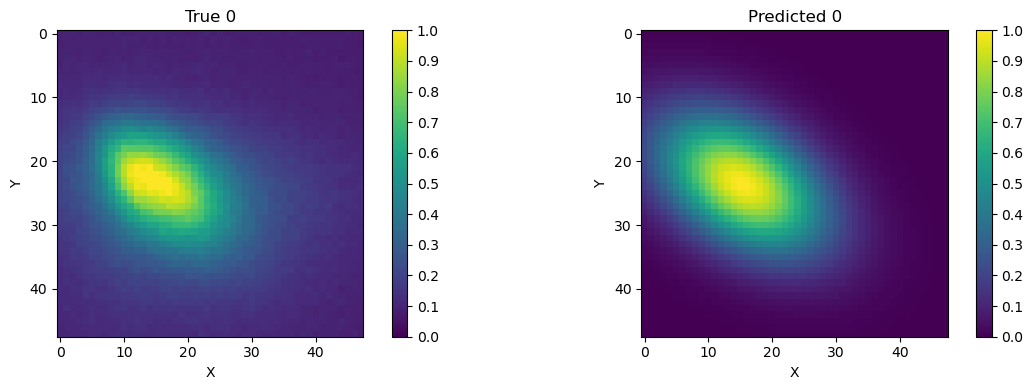

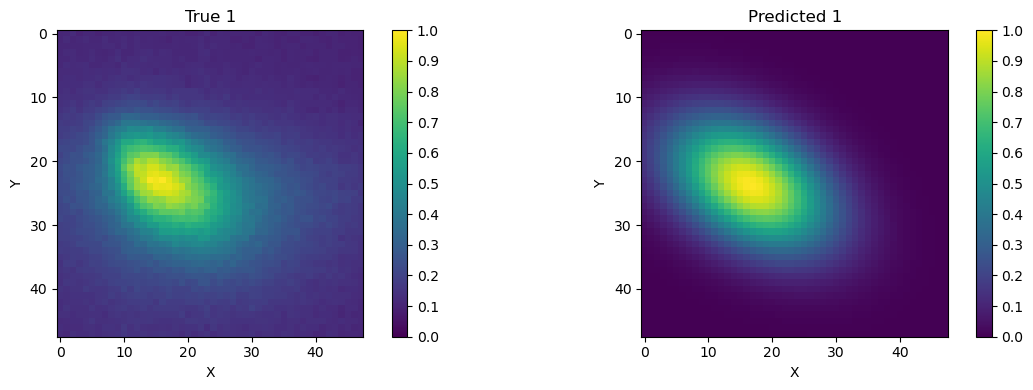

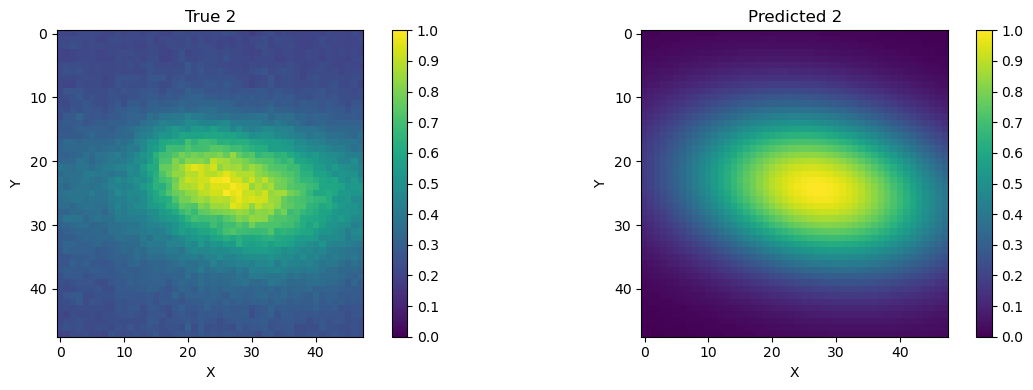

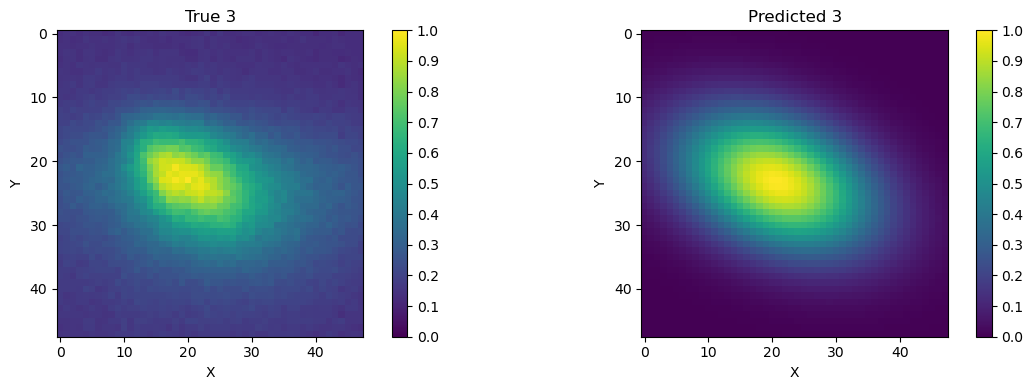

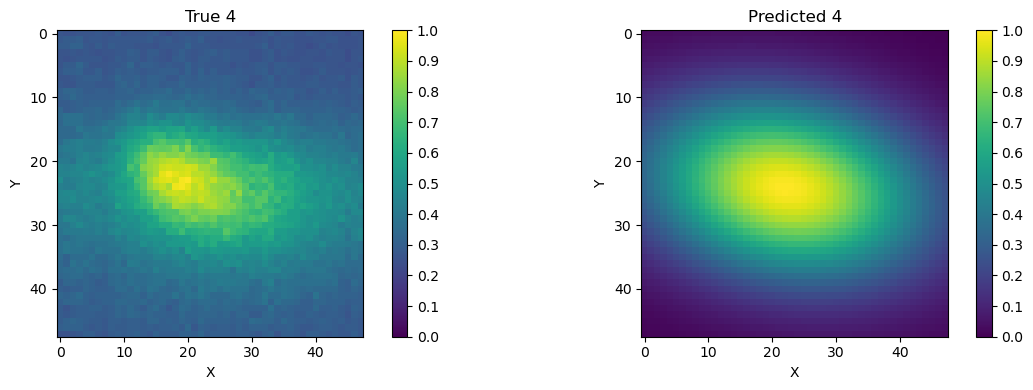

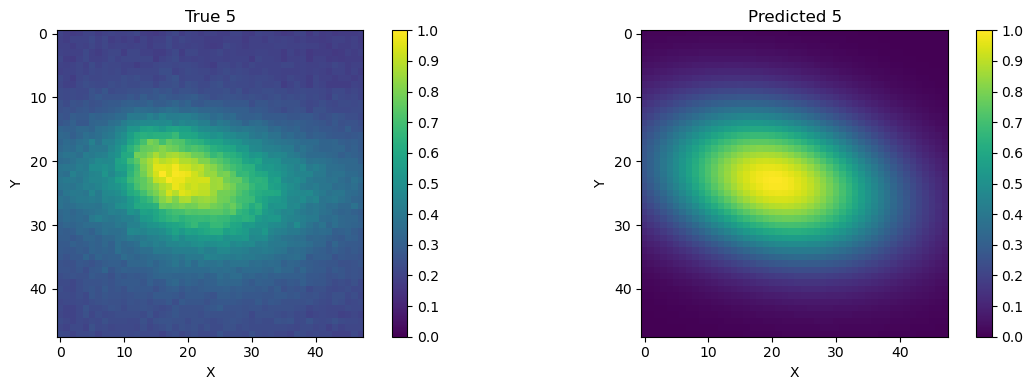

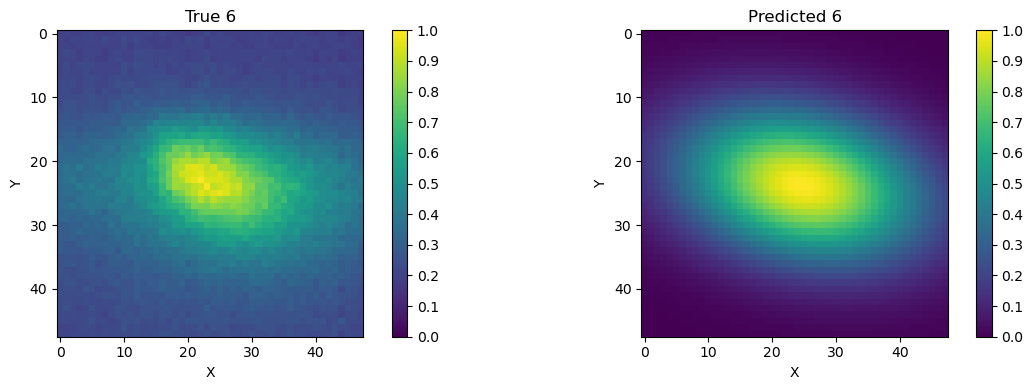

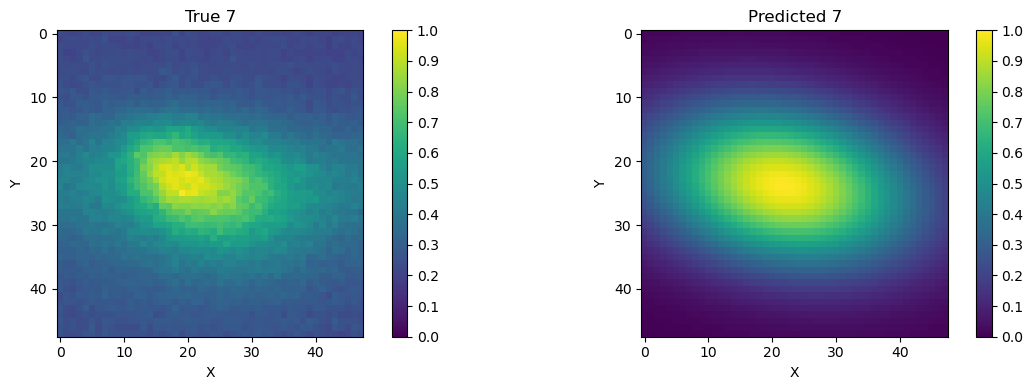

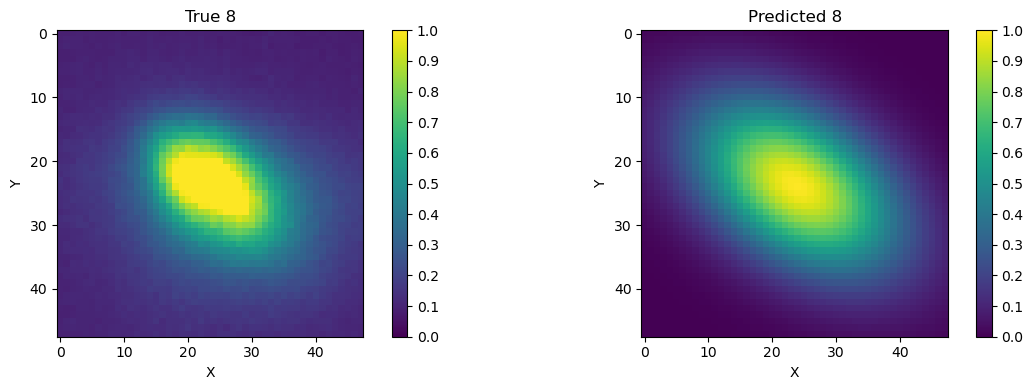

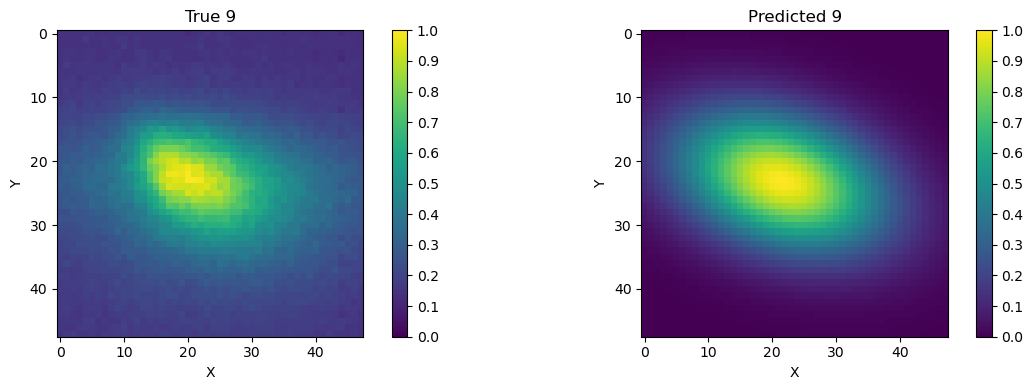

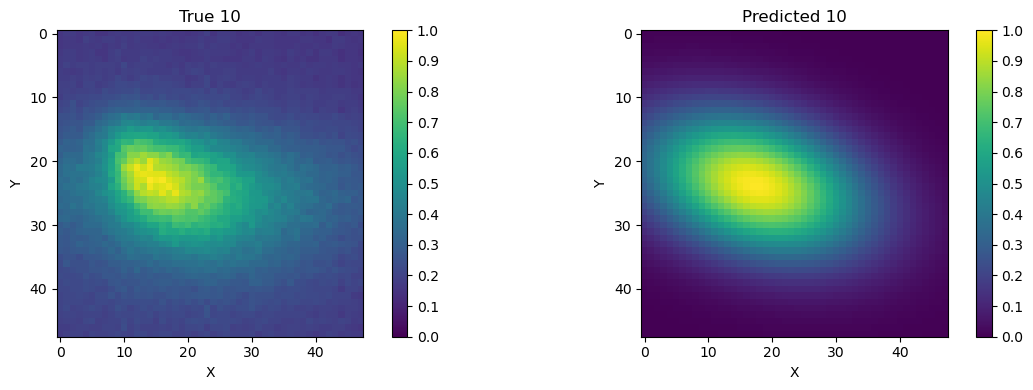

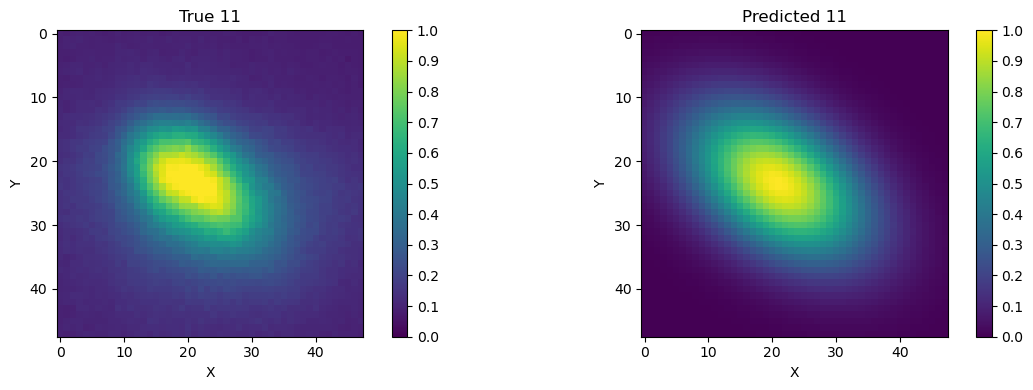

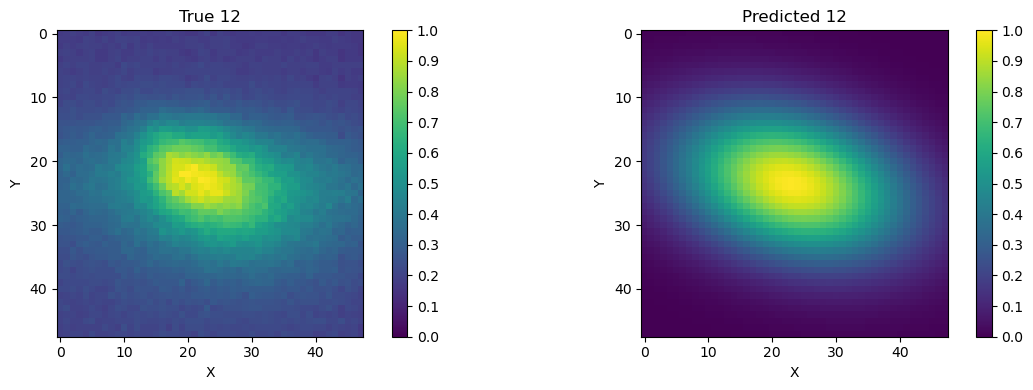

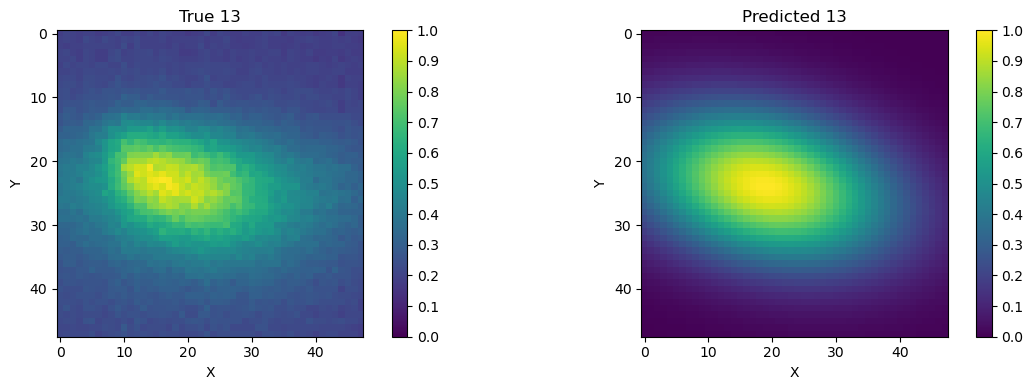

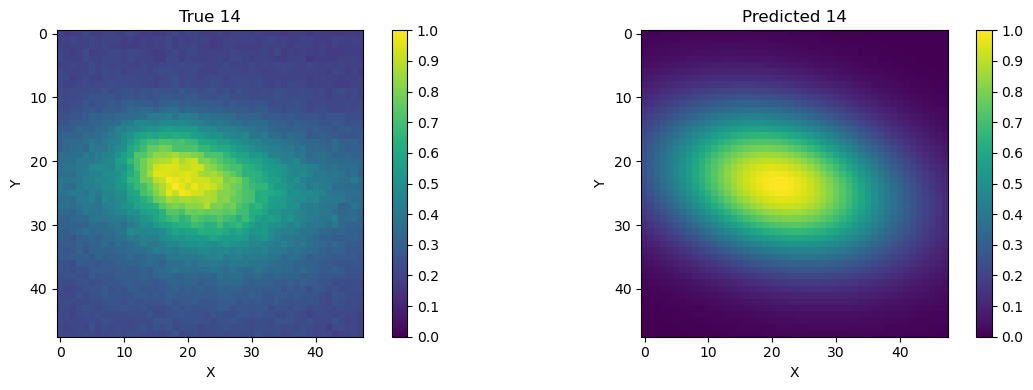

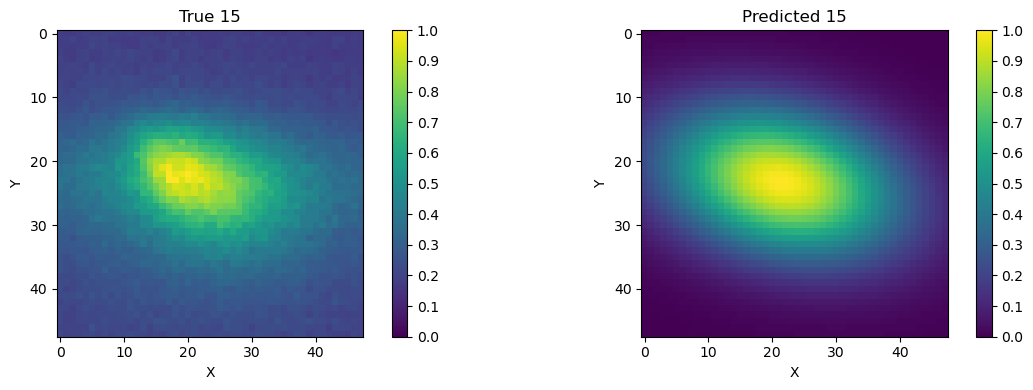

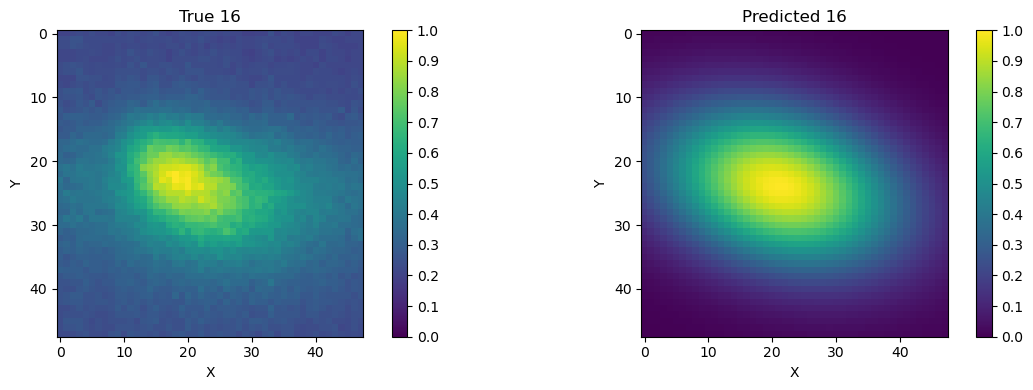

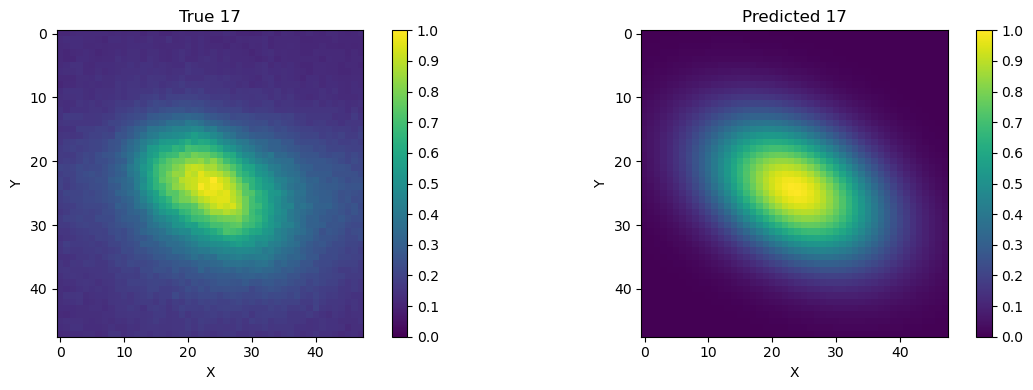

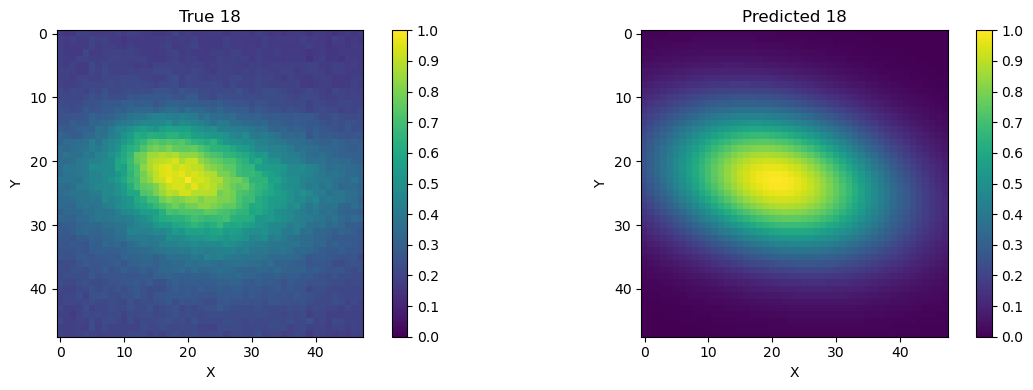

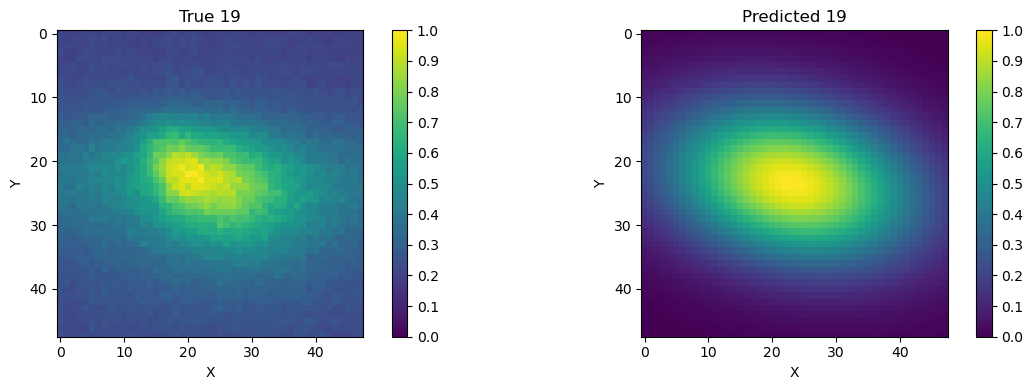

In [17]:

import matplotlib.pyplot as plt

for i in range(20):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))


    im0 = axs[0].imshow(data[i,0])
    im0.set_clim(0,1.0)
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0],ticks=np.arange(0, 1.1, 0.1))


    im1 = axs[1].imshow(outputs[i, 0].detach().cpu().numpy().squeeze())
    im1.set_clim(0,1.0)
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1],ticks=np.arange(0, 1.1, 0.1))

    plt.tight_layout()
    plt.savefig(f'OutputData/images_{i}.png')
    plt.show()



In [18]:
torch.save(net.state_dict(), 'PytorchLeNet_4848.pt')
#Saves the most recent model

In [19]:
#Model analyzer

model = LeNet5(GaussianGenerator((48,48)).float(),5)  # Replace num_classes with the appropriate number for your task

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}, Parameters: {param.numel()}")

Total number of parameters: 22239
Layer: layer1.0.weight, Shape: torch.Size([6, 1, 5, 5]), Parameters: 150
Layer: layer1.0.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.weight, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer2.0.weight, Shape: torch.Size([16, 6, 5, 5]), Parameters: 2400
Layer: layer2.0.bias, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.weight, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.bias, Shape: torch.Size([16]), Parameters: 16
Layer: fc.weight, Shape: torch.Size([98, 144]), Parameters: 14112
Layer: fc.bias, Shape: torch.Size([98]), Parameters: 98
Layer: fc1.weight, Shape: torch.Size([52, 98]), Parameters: 5096
Layer: fc1.bias, Shape: torch.Size([52]), Parameters: 52
Layer: fc2.weight, Shape: torch.Size([5, 52]), Parameters: 260
Layer: fc2.bias, Shape: torch.Size([5]), Parameters: 5


In [20]:
#testing pytorch model inference
model_pytorch=LeNet5_inference(5)
model_pytorch.load_state_dict(torch.load('PytorchLeNet_4848.pt'))
model_pytorch.eval() 


LeNet5_inference(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=144, out_features=98, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=98, out_features=52, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=52, out_features=5, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [21]:
path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_6']['spot_2'][0]
    img= img/img.max()
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
print(img_tensor.shape)
with torch.no_grad():
    output_pytorch = model_pytorch(img_tensor)
print(output_pytorch)

torch.Size([1, 1, 48, 48])
tensor([[22.9752, 19.4174,  9.9246,  6.1710,  0.4814]], dtype=torch.float64)
